# Data preprocessing
**Accomplishes:**
1. Compile master-array with image and text vectors for each item.
2. Re-classify each item (from initial API to client's labels).
3.  Downsample so data size is easy to manage and classes are unbiased.
[Future versions should use more representative dataset]

**Requires:**

- data/text_vecs.csv <-- file with text features that were generated with w2v. One row for each item, where:
    - column1 = id
    - column2 = category
    - columns 3:303 = values for the 300 features.
- data/allnpy_22.txt <-- file with image features that were generated with VGG-16's 2nd to last layer (ie, not softmax layer). One row for each item, where:
    - column1 = full filepath and name for each npy file
    - columns 2:4097 = values for the 4096 features.
- data/lookup_table.csv <-- lookup table with column headers where:
    - column1 = 'HAND' (desired categories) 
    - column2 = 'SS' (current categories)
    
**Output:**

File: 'data/handlabeled_vectors_1k.csv' with the 11k items we're using. Contains columns for id, 300 for text, 300 for image.

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.decomposition import TruncatedSVD


## 1. Compile master-array with image and text vectors for each item.

### Import text description vectors (which are the outputs from w2v)

In [3]:
dnames = ['id','category']
for i in range(1,301):
    dnames.append(str(i))
    
descriptiondf = pd.read_csv('data/text_vecs.csv',names=dnames)

### Import image vectors (which are the outputs from CNN)

In [9]:
# This takes a little while 
npylines = pd.read_csv('data/allnpy_22.txt', header=None)
npynames = npylines.columns.tolist()
npynames[0] = 'id'
npylines.columns = npynames

# Just need id, not full path
npyid = []
for i in range(0, len(npylines)):
    npyid.append(npylines.id[i].split('.')[0].split('/')[-1])
    
npylines['id'] = npyid

### Use only items which have both image and description vectors
Because of time & processing constraints we didn't process all the images, only ~2k from each category.

In [14]:
# Find union of vecs:
bothdf = pd.merge(descriptiondf, npylines, how='inner', on=['id'])

- bothdf columns:
    - [0] is 'id'
    - [1] is 'category'
    - [2:302] is text features
    - [302:4398] is image features 

In [15]:
# Make subset vectors for easy use later
id_vec = bothdf[bothdf.columns[0:2]]
text_vec = bothdf[bothdf.columns[2:302]]
image_vec = bothdf[bothdf.columns[302:4398]]

## 2. Re-classify each item (from initial API to client's labels).

### Import lookup table which matches current labels to the labels used by the clients

In [16]:
# Import hand-labeled categories
hand_df = pd.read_csv('data/lookup_table.csv', delimiter=',')

In [19]:
# Get hand-labeled categories for each item
hand = []
for i in range(0, len(id_vec)):
    a = hand_df[hand_df.SS==id_vec.category[i].strip()].HAND
    if (len(a)>0):
        hand.append(a.values[0])
    else:
        hand.append('NA')
        
handdf = pd.DataFrame()
handdf['hand'] = hand

# Get rid of NA rows (items not mapped to items the client uses)
all_withhand = pd.concat((id_vec, handdf, text_vec, image_vec), axis=1)
all_withhand = all_withhand[all_withhand.hand != 'NA']

In [20]:
# Get new subsets
hand_id_vec = all_withhand[all_withhand.columns[0:4]]
hand_text_vec = all_withhand[all_withhand.columns[4:304]]
hand_image_vec = all_withhand[all_withhand.columns[304:4399]]

## 3.  Downsample so data size is easy to manage and classes are unbiased.

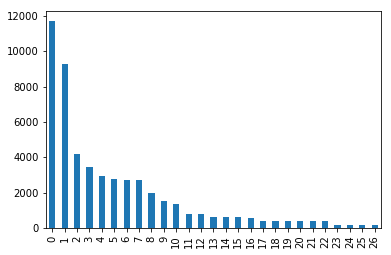

In [23]:
hand_id_vec.hand.value_counts().plot.bar(use_index=False)

Labels removed because of NDA. This shows that we currently have 27 categories which are pretty unbalanced. One category has nearly 12k, while many others only have ~1k, and some only have a few hundred.

#### As a quick solution, we'll use 1k items from each category. We will only use categories with at least 1k, and for categories with more than 1k, we will randomly sample 1k.

In [59]:
# Downsample observations
handover1k = all_withhand.hand.value_counts() > 1000
handover1k = handover1k[handover1k]
handover1k = handover1k.index

allhand = pd.DataFrame()
for cat in handover1k:
    mycat = all_withhand[all_withhand.hand==cat]
    mycat = mycat.sample(n=1000, random_state=0)
    allhand = allhand.append(mycat)
    
# Generate new subsets
ds_id_vec = allhand[allhand.columns[0:4]]
ds_text_vec = allhand[allhand.columns[4:304]]
ds_image_vec = allhand[allhand.columns[304:]]

In [60]:
len(ds_id_vec)

11000

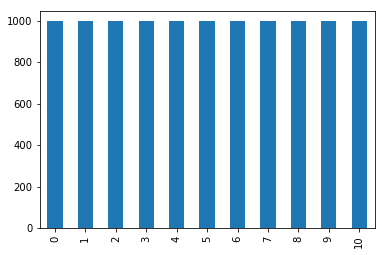

In [61]:
allhand.hand.value_counts().plot.bar(use_index=False)

Now we have 11 balanced categories. (11,000 total items in the dataset)

### Sanity checks to look at the features

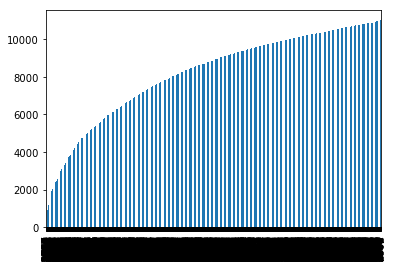

In [64]:
# W2V is fine.
# Plot number of zeros for each image feature, there seem to be a lot of zeros in there...
numZero = (ds_image_vec==0).sum()
numZero = numZero.sort_values()
numZero.plot.bar()

There are a lot of zeros in some features. Out of 11k, some have nearly all 0s. This is not terribly surprising as the last layer of VGG-16 is probably encoding some pretty high-level info for animal-classification, but not necessarily clothing classification.

### Downsample the features in each image vector (currently 4k+ features)

In [63]:
# 4k features with many zeros --> 300 dense features
svd = TruncatedSVD(n_components=300, n_iter=7, random_state=0)
allhand_id = allhand[allhand.columns[0:4]]
allhand_text = allhand[allhand.columns[4:304]]
allhand_imageFULL = allhand[allhand.columns[304:4399]]

allhand_image = svd.fit_transform(allhand_imageFULL)
allhand_image = pd.DataFrame(allhand_image)
allhand_image.index = allhand_imageFULL.index

allhand_reduced = pd.concat([allhand_id, allhand_text, allhand_image], axis=1)
allhand = allhand_reduced

### Output to file

In [70]:
# This takes a long time. ~30 min for full vecs, but those aren't used currently.
bothdf.to_csv('data/both_vectors.csv')

In [67]:
# Output vectors for just the 11k we'll use. 
allhand_reduced.to_csv('data/handlabeled_vectors_1k.csv')